In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# 1. Genel Resim


In [2]:
df = pd.read_csv("/kaggle/input/hitters-baseball-data/Hitters.csv")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    #print("##################### Tail #####################")
    #print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)


##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


# 2. Kategorik Değişken Analizi (Analysis of Categorical Variables)


        League  Ratio
League               
A          175 54.348
N          147 45.652
##########################################


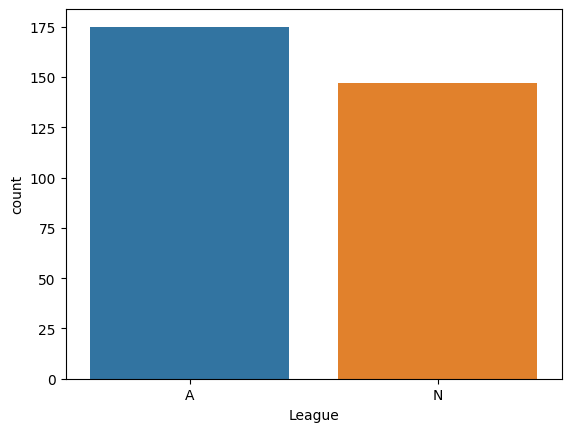

          Division  Ratio
Division                 
W              165 51.242
E              157 48.758
##########################################


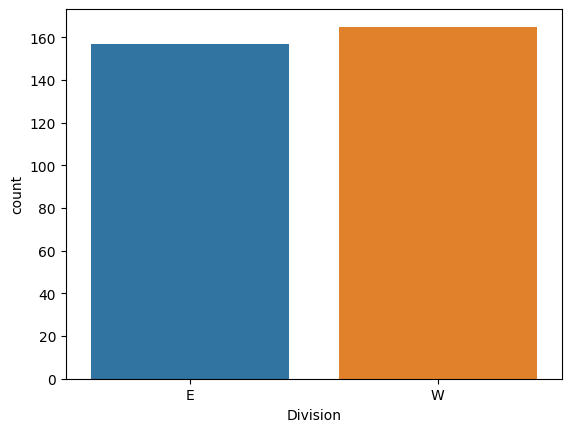

           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342
##########################################


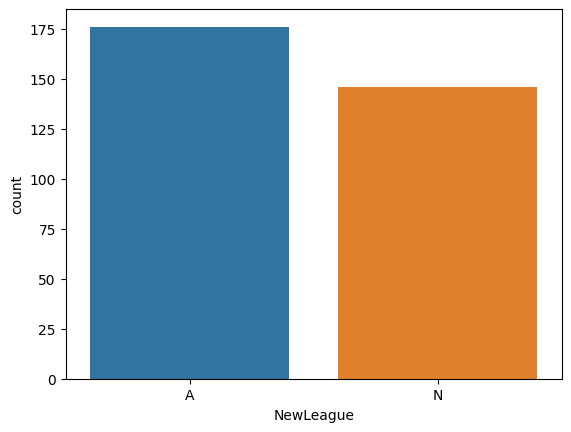

In [4]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

# 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)


count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


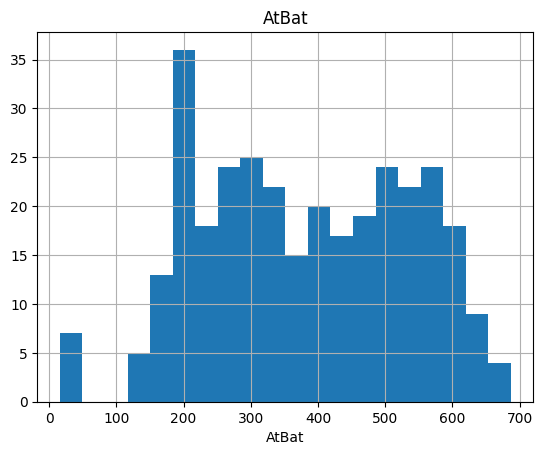

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


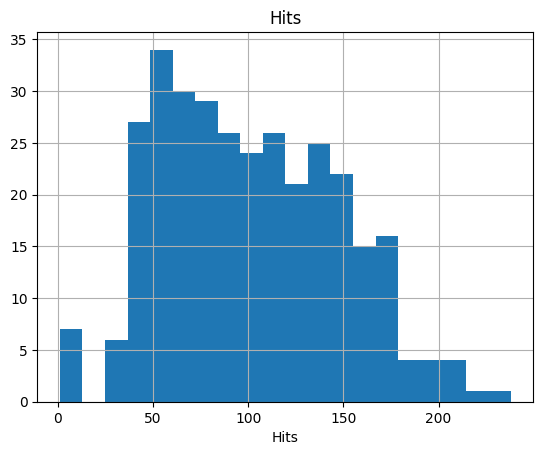

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


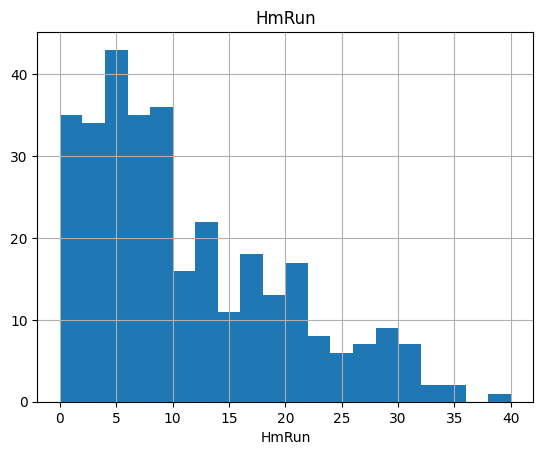

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


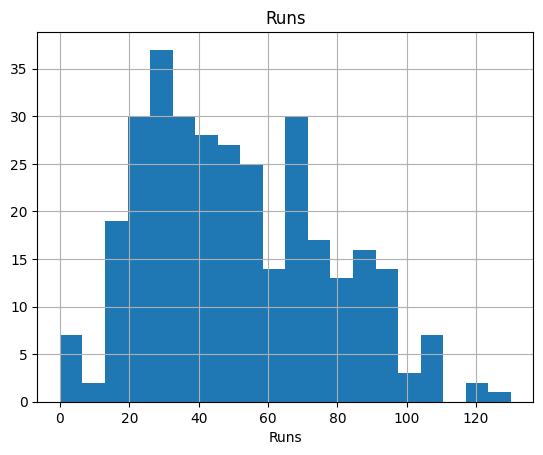

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


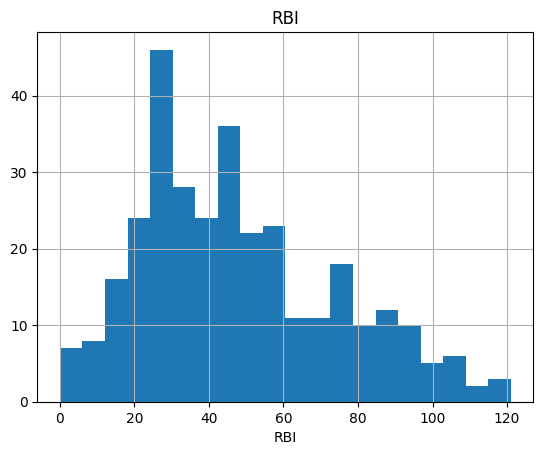

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


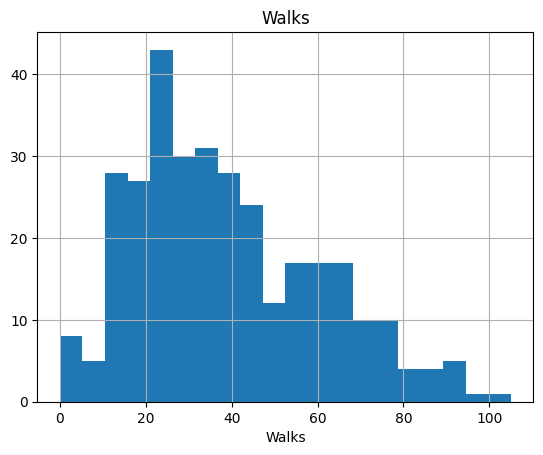

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


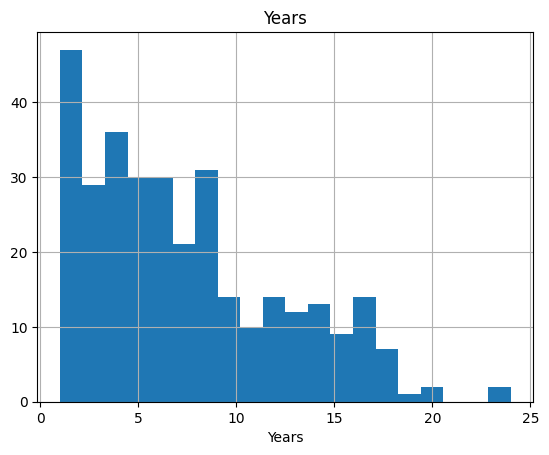

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


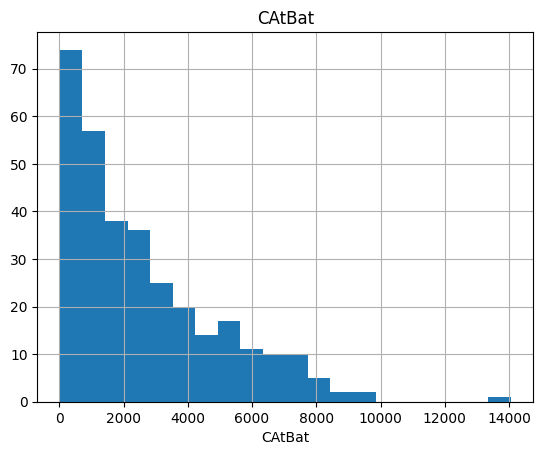

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


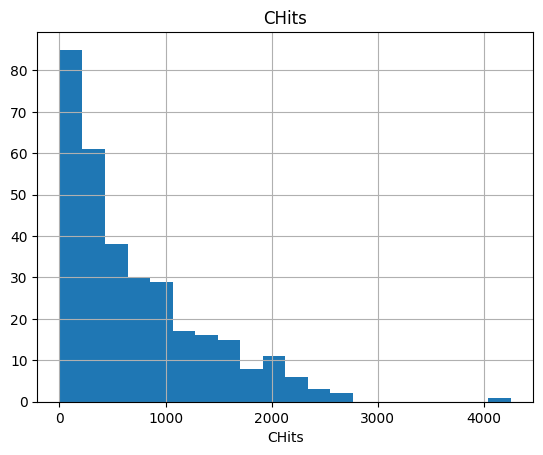

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


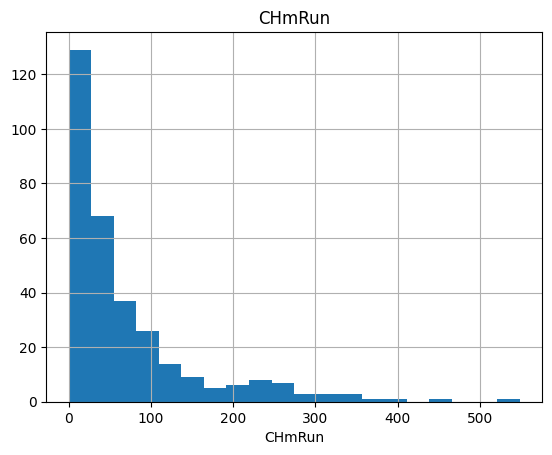

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


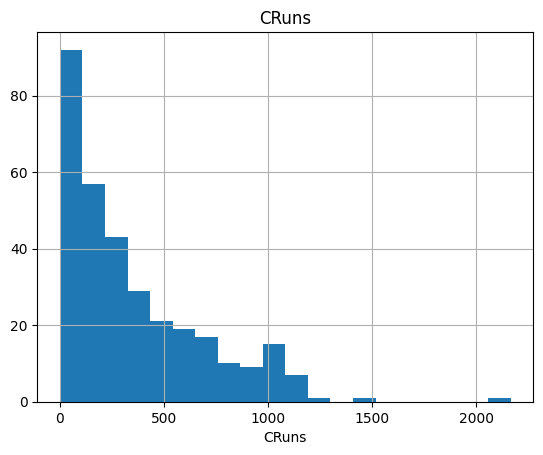

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


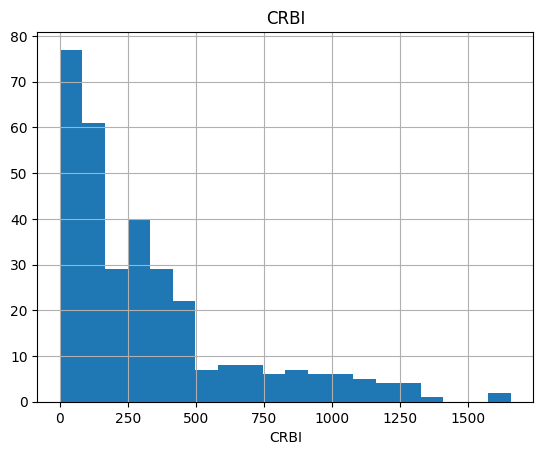

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


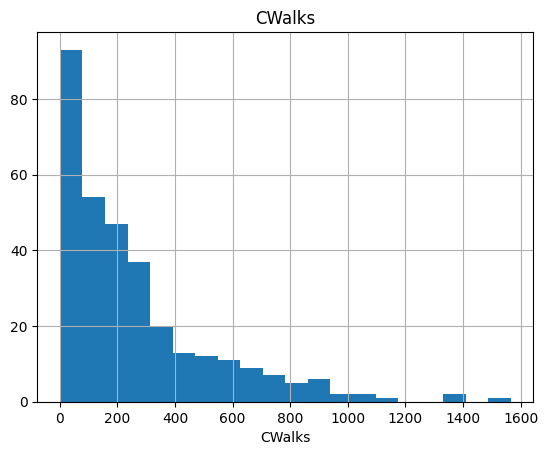

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


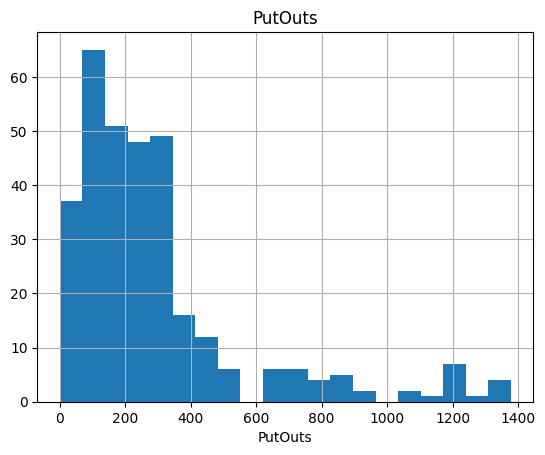

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


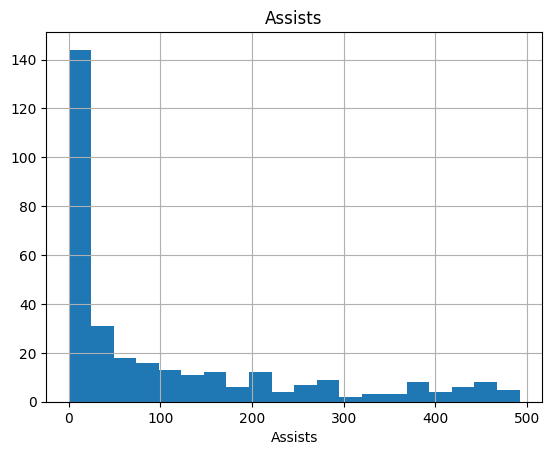

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


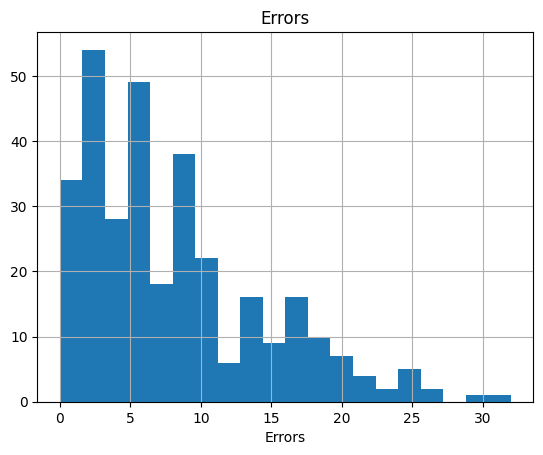

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


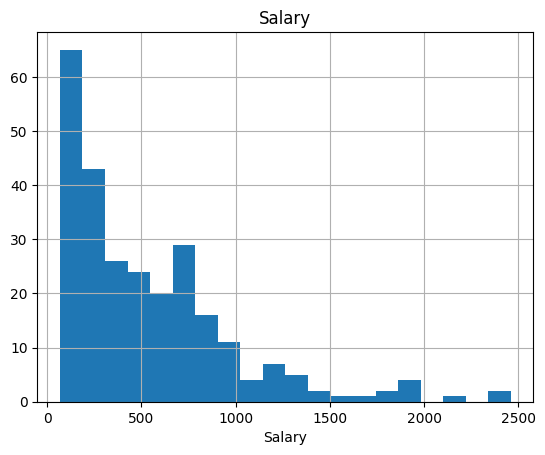

In [5]:
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)


# 4. Hedef Değişken Analizi (Analysis of Target Variable)


In [6]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




# 5. Korelasyon Analizi (Analysis of Correlation)


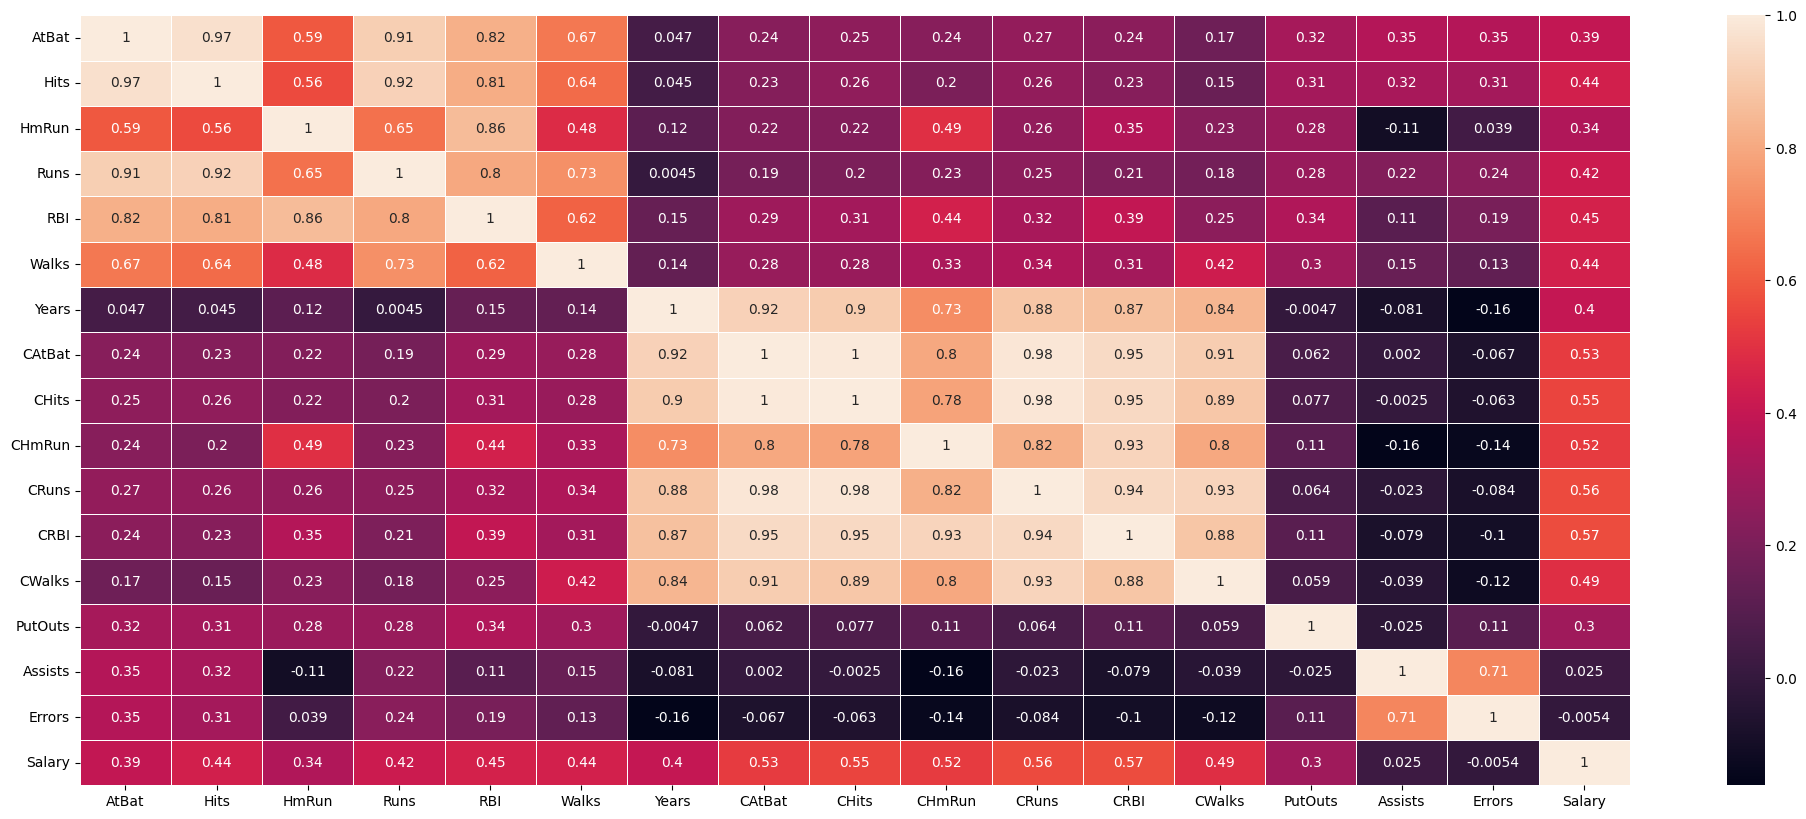

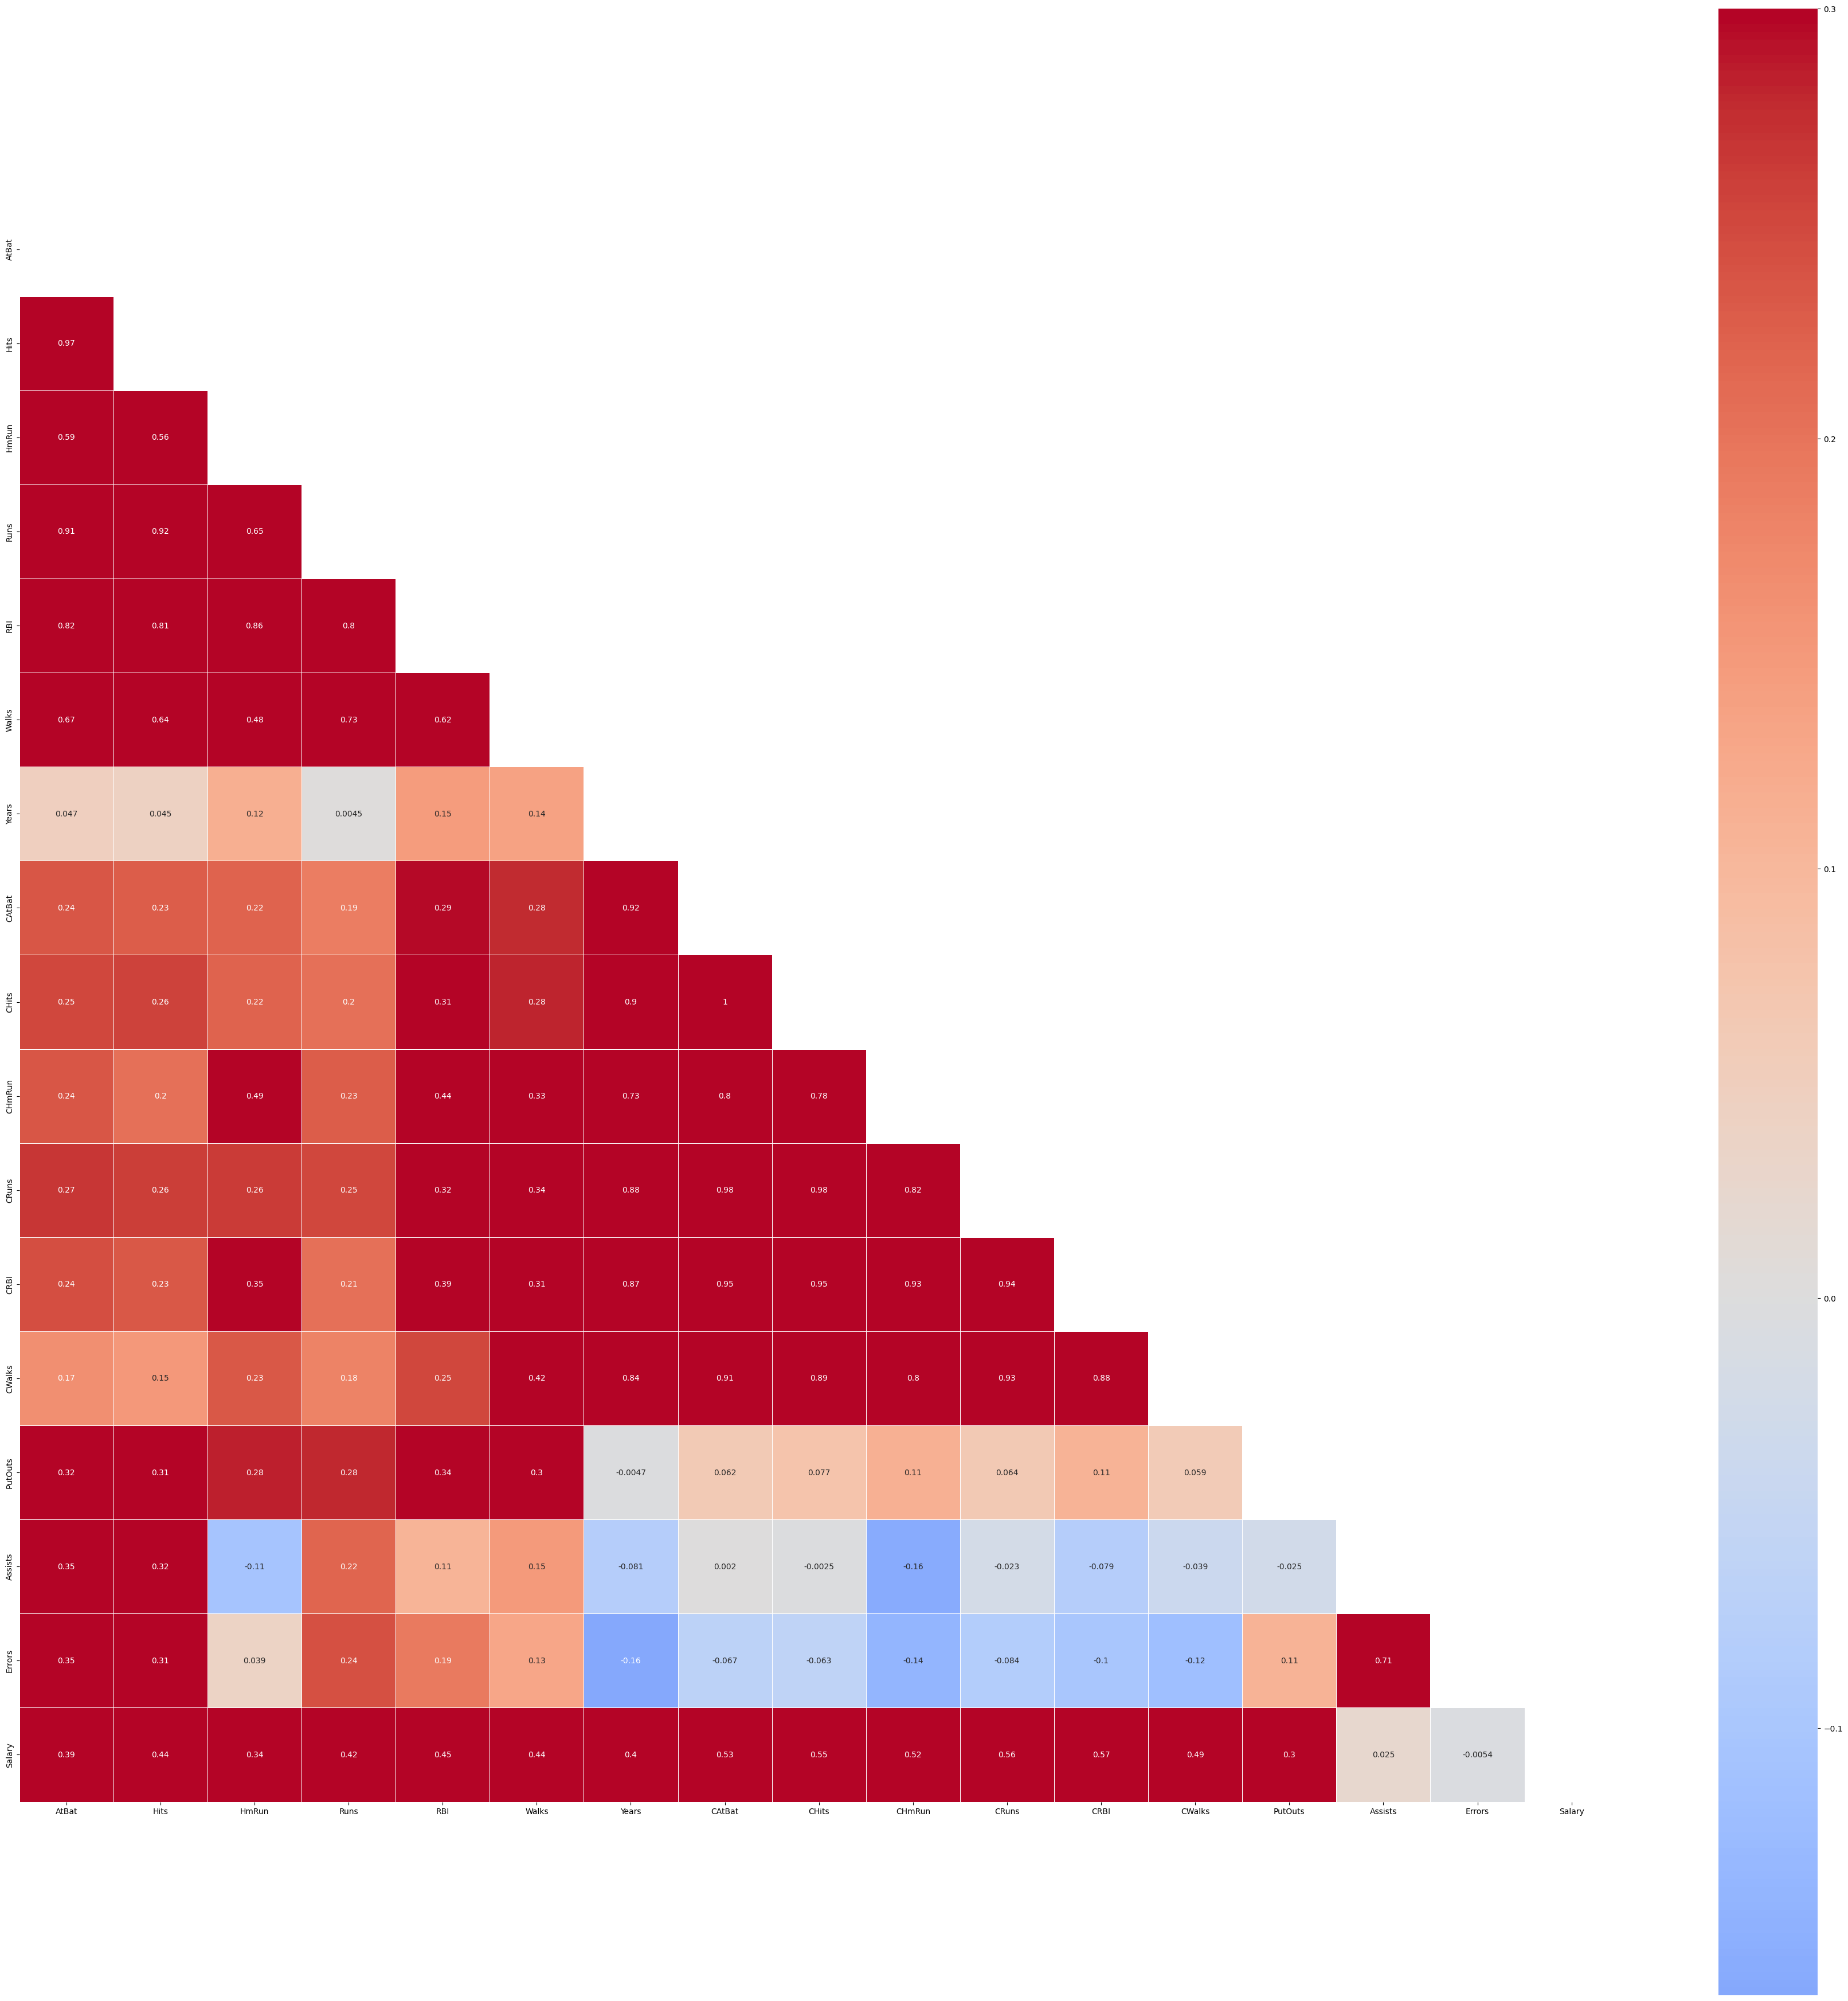

AtBat 0.39477094475973734
Hits 0.4386747378694112
HmRun 0.34302807815466363
Runs 0.4198585593019815
RBI 0.4494570879400337
Walks 0.44386726016297945
Years 0.40065699438268604
CAtBat 0.5261353096237892
CHits 0.5489095590351705
CHmRun 0.5249305595435935
CRuns 0.5626777110048051
CRBI 0.5669656856176524
CWalks 0.48982203628068005
PutOuts 0.30048035550600516
Assists 0.025436135647346703
Errors -0.005400701500953135


In [7]:
df[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.5, ax=ax)
plt.show()


# correlation with the final state of the variables
plt.figure(figsize=(45,45))
corr=df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df[num_cols].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show(block=True)

# kategorik degisken ordinal
# map - ortaokul -0 , lisans 1 , yükseklisans 2,


def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "Salary":
            pass
        else:
            correlation = dataframe[[col, "Salary"]].corr().loc[col, "Salary"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(df, num_cols)


# GELİŞMİŞ FONKSİYONEL KEŞİFÇİ VERİ ANALİZİ (ADVANCED FUNCTIONAL EDA)


# 1. Outliers (Aykırı Değerler)


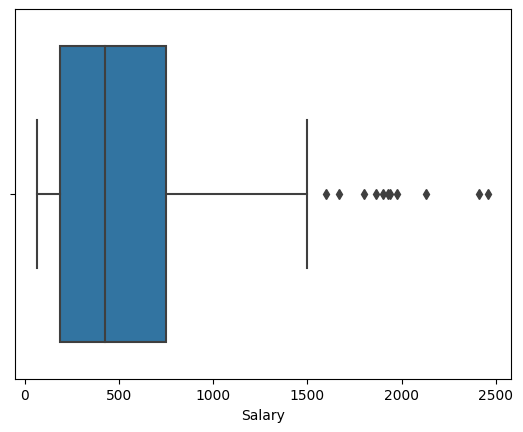

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [8]:
sns.boxplot(x=df["Salary"], data=df)
plt.show(block=True)


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

# 2. Missing Values (Eksik Değerler)


In [9]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)


        n_miss  ratio
Salary      59 18.320


In [10]:
# Eksik veri analizine uygun olarak 3 farkli yöntem kullanabiliriz.
df1 = df.copy()
df1.head()
cat_cols, num_cols, cat_but_car = grab_col_names(df1)




dff = pd.get_dummies(df1[cat_cols + num_cols], drop_first=True)
scaler = RobustScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
df1 = dff


print(df1.head())
print(df1.isnull().sum())

def eksik_veri_doldur(dataframe,method):
    df1 = dataframe.copy()
    cat_cols, num_cols, cat_but_car = grab_col_names(df1)
    if method == 1:
        dff = pd.get_dummies(df1[cat_cols + num_cols], drop_first=True)
        scaler = RobustScaler()
        dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
        imputer = KNNImputer(n_neighbors=5)
        dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
        dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
        df1 = dff
        pass


    elif method == 2:
        df1.loc[(df1["Salary"].isnull()) & (df1["League"] == "A") & (df["Division"] == "E"), "Salary"] = \
            df1.groupby(["League", "Division"])["Salary"].mean()["A", "E"]

        df1.loc[(df1["Salary"].isnull()) & (df1["League"] == "A") & (df["Division"] == "W"), "Salary"] = \
            df1.groupby(["League", "Division"])["Salary"].mean()["A", "W"]

        df1.loc[(df1["Salary"].isnull()) & (df1["League"] == "N") & (df["Division"] == "E"), "Salary"] = \
            df1.groupby(["League", "Division"])["Salary"].mean()["N", "E"]

        df1.loc[(df1["Salary"].isnull()) & (df1["League"] == "N") & (df["Division"] == "W"), "Salary"] = \
            df1.groupby(["League", "Division"])["Salary"].mean()["N", "W"]
        pass

    elif method == 3:
        # Drop NA
        # Eksik değer içeren tüm satırları silme
        df1.dropna(inplace=True)
        pass
    return df1

df1 = eksik_veri_doldur(df,method=1)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0
    AtBat    Hits  HmRun   Runs    RBI  Walks  Years   CAtBat    CHits  CHmRun   CRuns    CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  Division_W  \
0 293.000  66.000  1.000 30.000 29.000 14.000  1.000  293.000   66.000   1.000  30.000  29.000  14.000  446.000   33.000  20.000  82.900     0.000       0.000   
1 315.000  81.000  7.000 24.000 38.000 39.000 14.000 3449.000  835.000  69.000 321.000 414.000 375.000  632.000   43.000  10.000 475.000     1.000       1.000   
2 479.000 130.000 18.000 66.000 72.000 76.000  3.000 1624.000  457.000  63.000 224.000 266.000 263.000  648.625   82.000  14.000 480.000     0.000       1.000   
3 496.000 141.000 20.000 65.000 78.000 37.000 11.000 5628.000 1575.000 204.000 828.000 838.000 354.000  200.000   11.000   3.000 500.000     1.000       0.000   
4 321.000  87.000 10.000 39.000 42.000 30.000  2.000  396.000  101.000  12.000  48.000  46.000  33.000 

# 3. Feature Extraction (Özellik Çıkarımı)


In [11]:
new_num_cols=[col for col in num_cols if col!="Salary"]
df1[new_num_cols]=df1[new_num_cols]+0.0000000001

df1["Hits_Success"] = (df1["Hits"] / df1["AtBat"]) * 100
df1['NEW_RBI'] = df1['RBI'] / df1['CRBI']
df1['NEW_Walks'] = df1['Walks'] / df1['CWalks']
df1['NEW_PutOuts'] = df1['PutOuts'] * df1['Years']
df1['NEW_Hits'] = df1['Hits'] / df1['CHits'] + df1['Hits']
df1["NEW_CRBI*CATBAT"] = df1['CRBI'] * df1['CAtBat']
df1["NEW_Chits"] = df1["CHits"] / df1["Years"]
df1["NEW_CHmRun"] = df1["CHmRun"] * df1["Years"]
df1["NEW_CRuns"] = df1["CRuns"] / df1["Years"]
df1["NEW_Chits"] = df1["CHits"] * df1["Years"]
df1["NEW_RW"] = df1["RBI"] * df1["Walks"]
df1["NEW_RBWALK"] = df1["RBI"] / df1["Walks"]
df1["NEW_CH_CB"] = df1["CHits"] / df1["CAtBat"]
df1["NEW_CHm_CAT"] = df1["CHmRun"] / df1["CAtBat"]
df1['NEW_Diff_Atbat'] = df1['AtBat'] - (df1['CAtBat'] / df1['Years'])
df1['NEW_Diff_Hits'] = df1['Hits'] - (df1['CHits'] / df1['Years'])
df1['NEW_Diff_HmRun'] = df1['HmRun'] - (df1['CHmRun'] / df1['Years'])
df1['NEW_Diff_Runs'] = df1['Runs'] - (df1['CRuns'] / df1['Years'])
df1['NEW_Diff_RBI'] = df1['RBI'] - (df1['CRBI'] / df1['Years'])
df1['NEW_Diff_Walks'] = df1['Walks'] - (df1['CWalks'] / df1['Years'])

def feature_ext(df1):
    cat_cols, num_cols, cat_but_car = grab_col_names(df1)
    new_num_cols = [col for col in num_cols if col != "Salary"]
    df1[new_num_cols] = df1[new_num_cols] + 0.0000000001

    df1['NEW_Hits'] = df1['Hits'] / df1['CHits'] + df1['Hits']
    df1['NEW_RBI'] = df1['RBI'] / df1['CRBI']
    df1['NEW_Walks'] = df1['Walks'] / df1['CWalks']
    df1['NEW_PutOuts'] = df1['PutOuts'] * df1['Years']
    df1["Hits_Success"] = (df1["Hits"] / df1["AtBat"]) * 100
    df1["NEW_CRBI*CATBAT"] = df1['CRBI'] * df1['CAtBat']
    df1["NEW_RBI"] = df1["RBI"] / df1["CRBI"]
    df1["NEW_Chits"] = df1["CHits"] / df1["Years"]
    df1["NEW_CHmRun"] = df1["CHmRun"] * df1["Years"]
    df1["NEW_CRuns"] = df1["CRuns"] / df1["Years"]
    df1["NEW_Chits"] = df1["CHits"] * df1["Years"]
    df1["NEW_RW"] = df1["RBI"] * df1["Walks"]
    df1["NEW_RBWALK"] = df1["RBI"] / df1["Walks"]
    df1["NEW_CH_CB"] = df1["CHits"] / df1["CAtBat"]
    df1["NEW_CHm_CAT"] = df1["CHmRun"] / df1["CAtBat"]
    df1['NEW_Diff_Atbat'] = df1['AtBat'] - (df1['CAtBat'] / df1['Years'])
    df1['NEW_Diff_Hits'] = df1['Hits'] - (df1['CHits'] / df1['Years'])
    df1['NEW_Diff_HmRun'] = df1['HmRun'] - (df1['CHmRun'] / df1['Years'])
    df1['NEW_Diff_Runs'] = df1['Runs'] - (df1['CRuns'] / df1['Years'])
    df1['NEW_Diff_RBI'] = df1['RBI'] - (df1['CRBI'] / df1['Years'])
    df1['NEW_Diff_Walks'] = df1['Walks'] - (df1['CWalks'] / df1['Years'])
    return df1

# 4. One-Hot Encoding


In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    for col in dataframe.columns:
        if dataframe[col].dtype == 'bool':
            dataframe[col] = dataframe[col].astype(int)
    return dataframe

df1 = one_hot_encoder(df1, cat_cols, drop_first=True)

Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


# 5. Feature Scaling (Özellik Ölçeklendirme)


Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


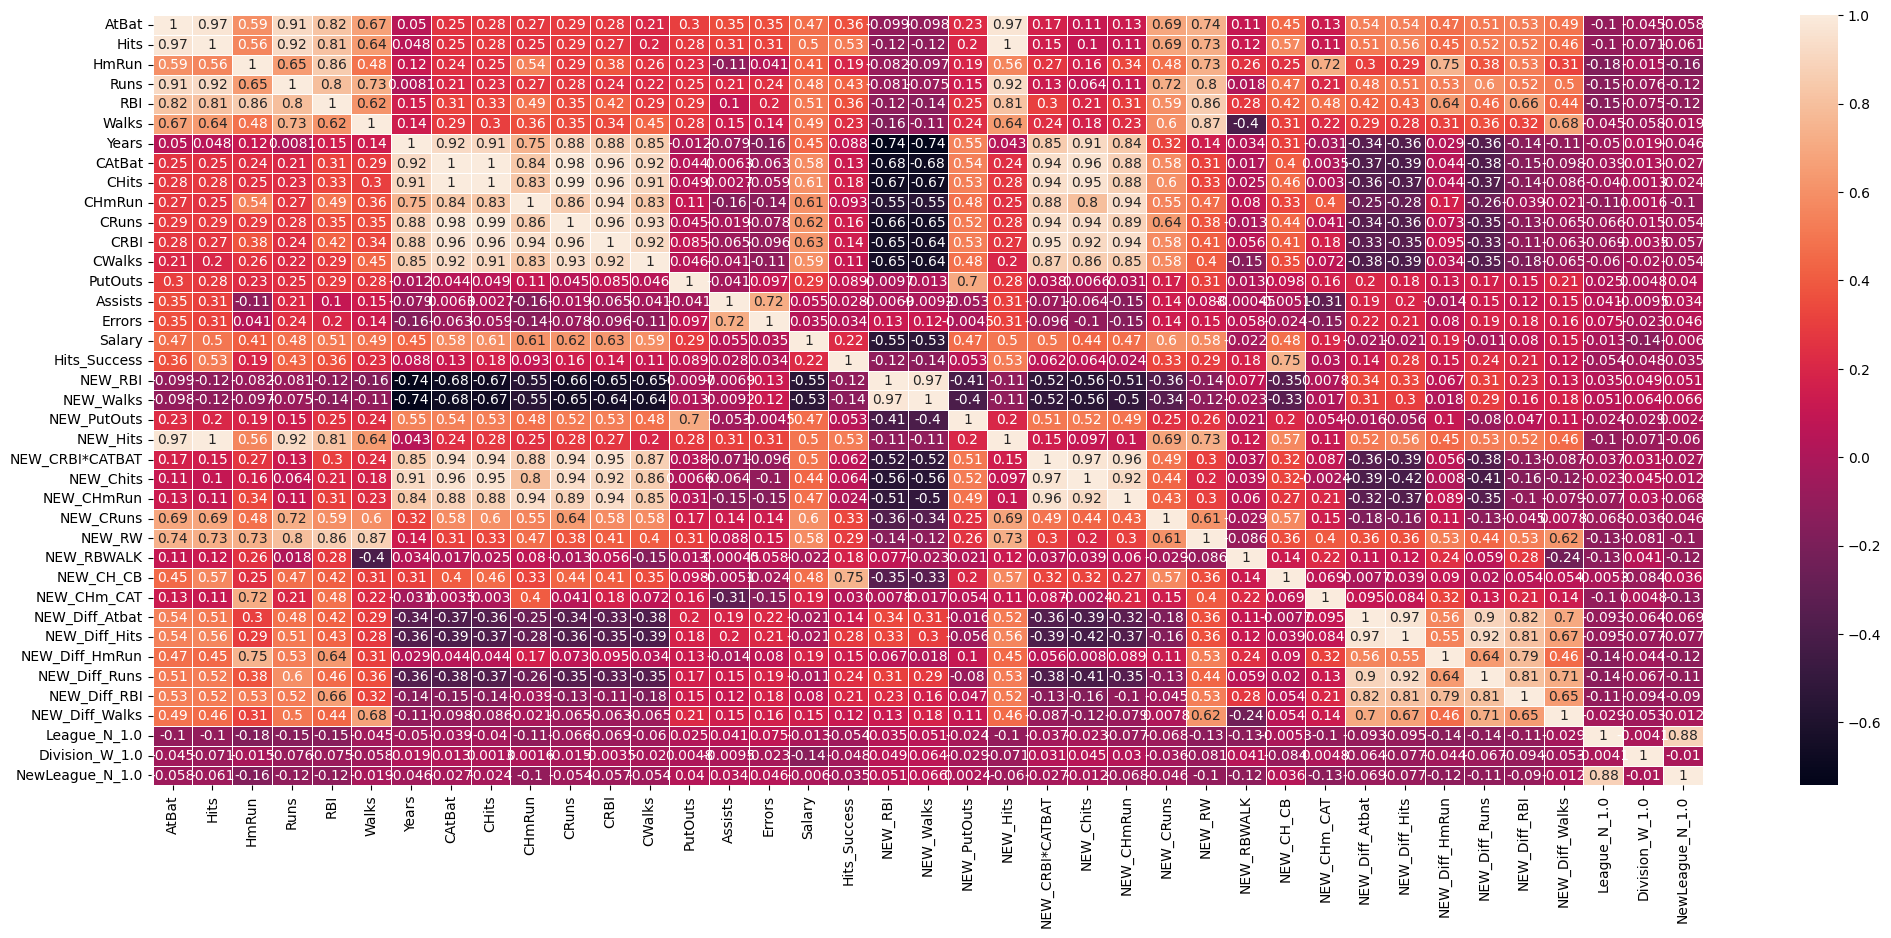

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])
df1.head()


def feature_scaling(dataframe, num_cols):
    # Özellik ölçeklendirme işlemleri
    scaler = StandardScaler()
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    num_cols = [col for col in num_cols if col not in ["Salary"]]
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
    return dataframe

# Correlation Analysis
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df1.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

#               MODELING                    


In [14]:
df1.isnull().sum().sum()
#df1.dropna(inplace=True)
y = df1["Salary"]
X = df1.drop(["Salary"], axis=1)

X.shape
y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=46)

# Model Evaluation for Linear Regression
linreg = LinearRegression()
model = linreg.fit(X_train,y_train)
y_pred = model.predict(X_train)
lin_train_rmse =np.sqrt(mean_squared_error(y_train,y_pred))
print("LINEAR REGRESSION TRAIN RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train,y_pred))))

lin_train_r2 = linreg.score(X_train,y_train)
print("LINEAR REGRESSION TRAIN R-SQUARED:", "{:,.3f}".format(linreg.score(X_train,y_train)))

y_pred = model.predict(X_test)
lin_test_rmse =np.sqrt(mean_squared_error(y_test,y_pred))
print("LINEAR REGRESSION TEST RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

lin_test_r2 = linreg.score(X_test,y_test)
print("LINEAR REGRESSION TEST R-SQUARED:", "{:,.3f}".format(linreg.score(X_test,y_test)))



LINEAR REGRESSION TRAIN RMSE: 190.90
LINEAR REGRESSION TRAIN R-SQUARED: 0.757
LINEAR REGRESSION TEST RMSE: 194.99
LINEAR REGRESSION TEST R-SQUARED: 0.721


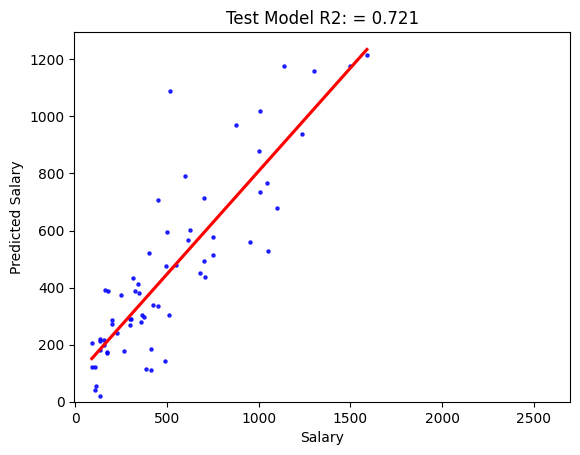

In [15]:
# Test part regplot:
g = sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'b', 's': 5},
                ci=False, color="r")
g.set_title(f"Test Model R2: = {linreg.score(X_test, y_test):.3f}")
g.set_ylabel("Predicted Salary")
g.set_xlabel("Salary")
plt.xlim(-5, 2700)
plt.ylim(bottom=0)
plt.show(block=True)

In [16]:
# Cross Validation Score
print("LINEAR REGRESSION CROSS_VAL_SCORE:", "{:,.3f}".format(np.mean(np.sqrt(-cross_val_score(model,
                                 X,
                                 y,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))))

LINEAR REGRESSION CROSS_VAL_SCORE: 224.551


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Adding a constant to the model (necessary for statsmodels)
X_train_sm = sm.add_constant(X_train)

# Fitting the model using statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Getting the summary of the regression model
model_summary = model_sm.summary()
model_summary

def model_training(dataframe,target_col):
    y = dataframe[target_col]
    X = dataframe.drop([target_col], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=46)

    # Model Evaluation for Linear Regression
    linreg = LinearRegression()
    model = linreg.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    lin_train_rmse =np.sqrt(mean_squared_error(y_train,y_pred))
    print("LINEAR REGRESSION TRAIN RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train,y_pred))))

    lin_train_r2 = linreg.score(X_train,y_train)
    print("LINEAR REGRESSION TRAIN R-SQUARED:", "{:,.3f}".format(linreg.score(X_train,y_train)))

    y_pred = model.predict(X_test)
    lin_test_rmse =np.sqrt(mean_squared_error(y_test,y_pred))
    print("LINEAR REGRESSION TEST RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

    lin_test_r2 = linreg.score(X_test,y_test)
    print("LINEAR REGRESSION TEST R-SQUARED:", "{:,.3f}".format(linreg.score(X_test,y_test)))
    # Adding a constant to the model (necessary for statsmodels)
    #X_train_sm = sm.add_constant(X_train)
    # Fitting the model using statsmodels
    #model_sm = sm.OLS(y_train, X_train_sm).fit()
    # Getting the summary of the regression model
    #model_summary = model_sm.summary()
    #return model_summary

In [18]:
##### Functions ######

def sonuc(df,method):
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    df1 = eksik_veri_doldur(df,method)
    df1 = feature_ext(df1)
    cat_cols, num_cols, cat_but_car = grab_col_names(df1)
    df1 = one_hot_encoder(df1, cat_cols, drop_first=True)
    df1 = feature_scaling(df1, num_cols)
    model = model_training(df1,"Salary")

sonuc(df,method=1)


Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0
Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0
Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 3
Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3
Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3
LINEAR REGRESSION TRAIN RMSE: 190.90
LINEAR REGRESSION TRAIN R-SQUARED: 0.757
LINEAR REGRESSION TEST RMSE: 194.99
LINEAR REGRESSION TEST R-SQUARED: 0.721


In [19]:
from sklearn.preprocessing import LabelEncoder

# Tüm kategorik sütunları dönüştürme
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Eksik değerleri kontrol etme
print(df.isnull().sum())

# Eksik değerleri doldurma veya çıkarma
df = df.dropna()

print(X.head())
print(y.head())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
   AtBat   Hits  HmRun   Runs    RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Hits_Success  NEW_RBI  NEW_Walks  \
0 -0.574 -0.755 -1.130 -0.805 -0.728 -1.147 -1.318  -1.043 -1.035  -0.956 -1.023 -0.995  -1.036    1.049   -0.549   1.977        -0.956    2.214      2.285   
1 -0.430 -0.432 -0.434 -1.036 -0.384  0.013  1.346   0.369  0.204   0.119 -0.105  0.363   0.582    2.060   -0.471   0.337        -0.076   -0.798     -0.767   
2  0.640  0.625  0.840  0.582  0.918  1.729 -0.908  -0.448 -0.405   0.024 -0.411 -0.159   0.080    2.151   -0.170   0.993         0.317   -0.204     -0.137   
3  0.751  0.862  1.072  0.543  

In [20]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

# Sayısal olmayan sütunları dönüştürme
X = pd.get_dummies(X, drop_first=True)

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor(verbose=-1)),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


RMSE: 283.9967 (LR) 
RMSE: 283.7451 (Ridge) 
RMSE: 283.1507 (Lasso) 
RMSE: 282.5171 (ElasticNet) 
RMSE: 281.7114 (KNN) 
RMSE: 322.5607 (CART) 
RMSE: 236.8528 (RF) 
RMSE: 391.2458 (SVR) 
RMSE: 243.3945 (GBM) 
RMSE: 258.7043 (XGBoost) 
RMSE: 244.0875 (LightGBM) 
RMSE: 230.8253 (CatBoost) 


In [21]:
################################################
# Random Forests
################################################

rf_model = RandomForestRegressor(random_state=17)

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

################################################
# GBM Model
################################################

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

################################################
# LightGBM
################################################

lgbm_model = LGBMRegressor(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

################################################
# CatBoost
################################################

catboost_model = CatBoostRegressor(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


226.3494371023806

In [22]:
######################################################
#  Automated Hyperparameter Optimization
######################################################

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params),
              ("CatBoost", CatBoostRegressor(), catboost_params)]


best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## RF ##########
RMSE: 237.0133 (RF) 
RMSE (After): 233.9836 (RF) 
RF best params: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 200}

########## GBM ##########
RMSE: 242.0419 (GBM) 
RMSE (After): 227.9669 (GBM) 
GBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}

########## LightGBM ##########
RMSE: 244.0875 (LightGBM) 
RMSE (After): 241.994 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

########## CatBoost ##########
Learning rate set to 0.032591
0:	learn: 402.2913932	total: 2.9ms	remaining: 2.9s
1:	learn: 396.6209217	total: 4.65ms	remaining: 2.32s
2:	learn: 390.8440467	total: 6.25ms	remaining: 2.08s
3:	learn: 385.0689216	total: 8.01ms	remaining: 1.99s
4:	learn: 379.2759452	total: 9.61ms	remaining: 1.91s
5:	learn: 373.4963521	total: 11.2ms	remaining: 1.85s
6:	learn: 367.7172289	total: 13ms	remaining: 1.84s
7:	learn: 362.0602969	total: 14.7ms	r

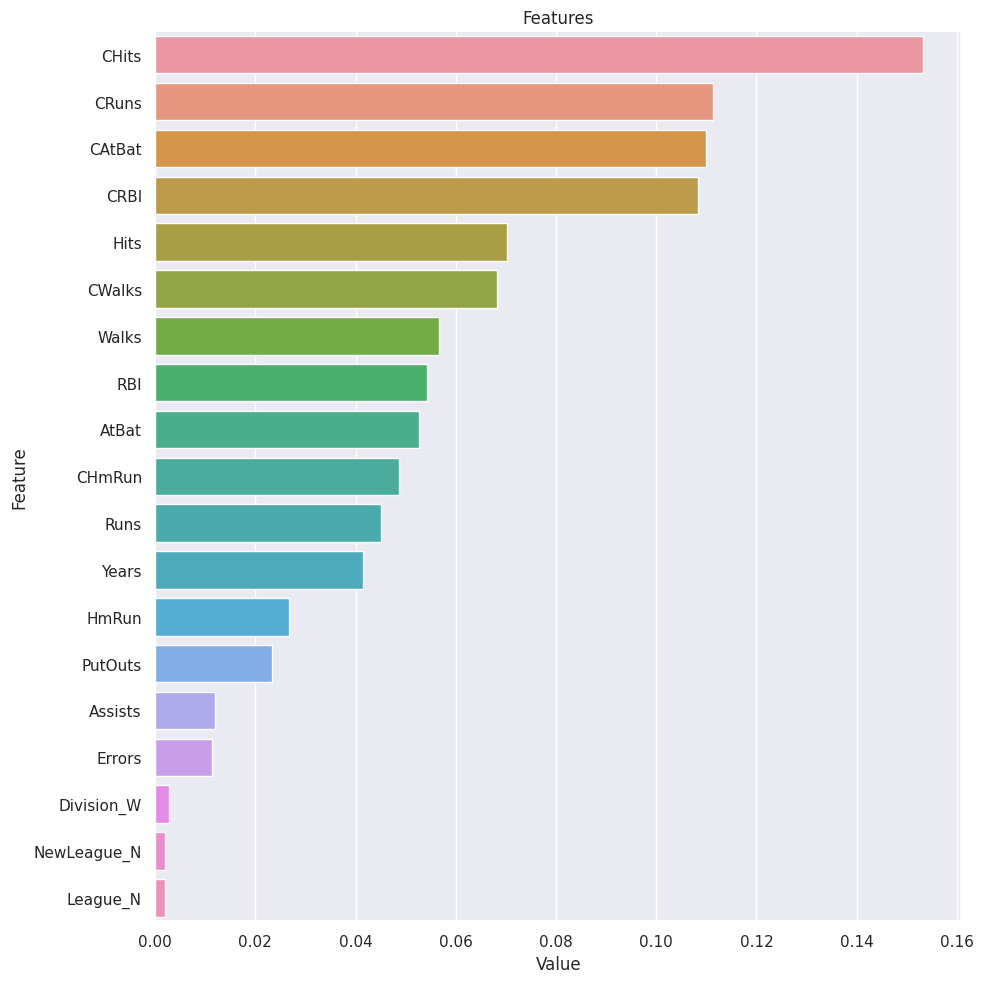

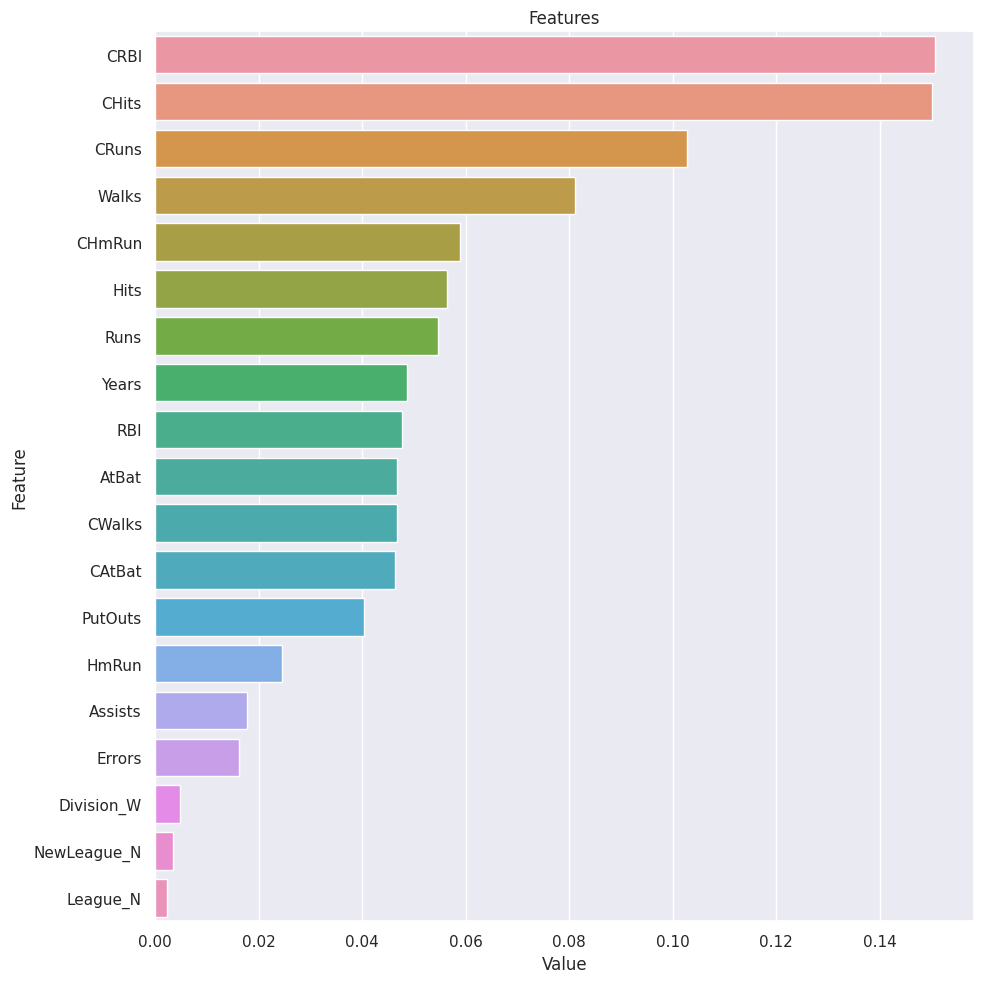

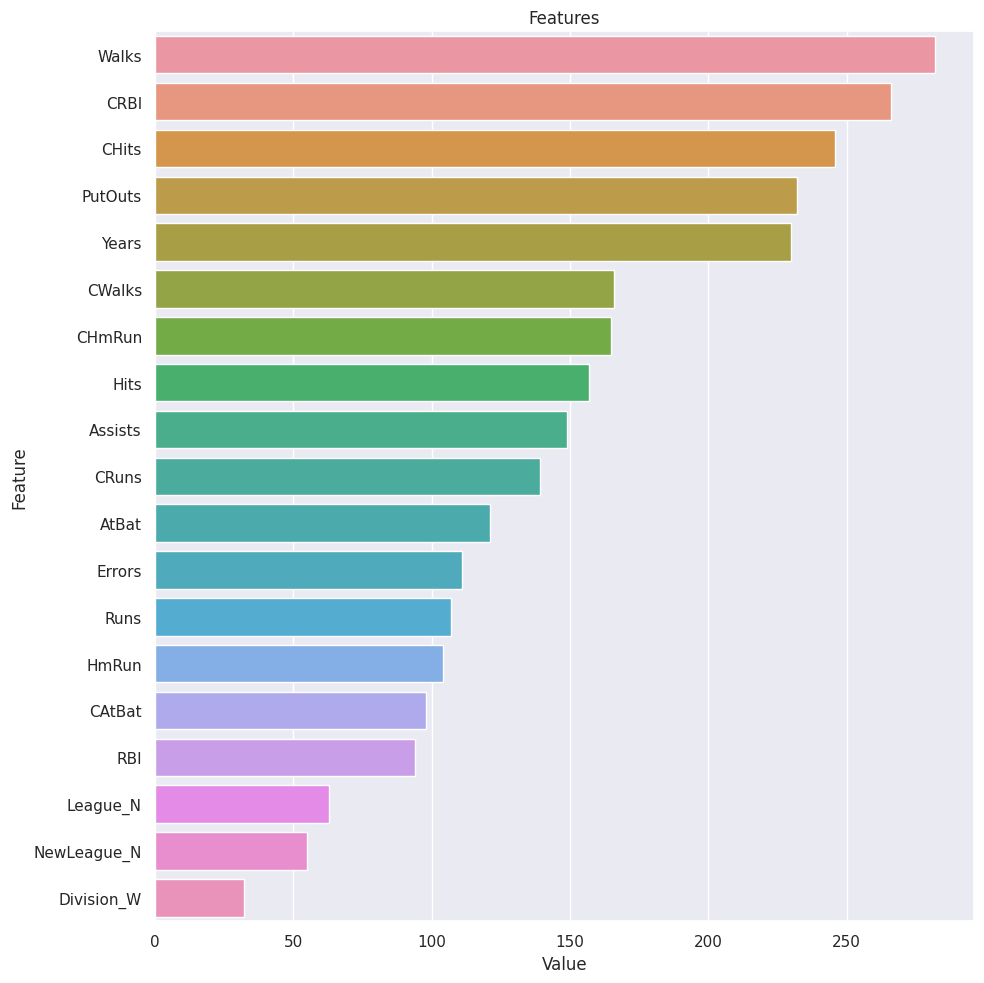

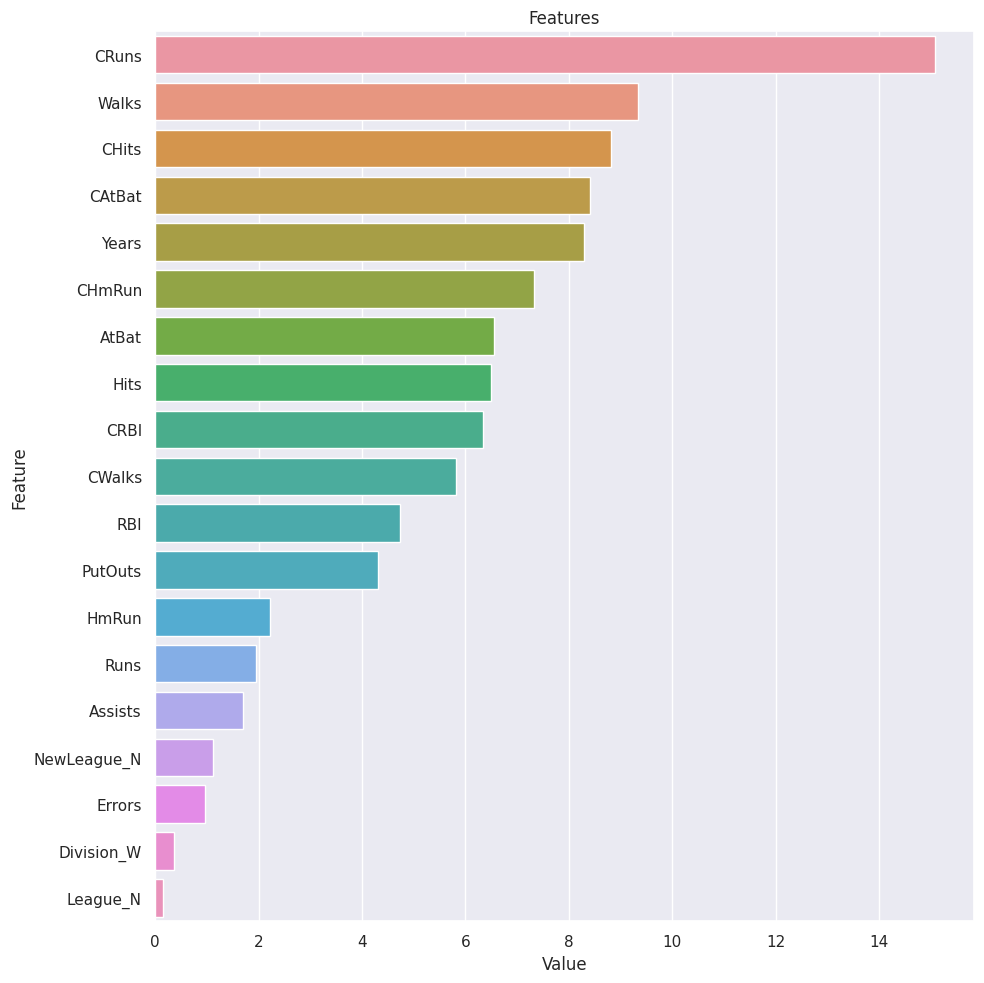

In [23]:
################################################
# Feature Importance
################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)
